## Importing Libraries

In [57]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

## Importing the Dataset & Pre-processing

In [58]:
# importing the data
df = pd.read_csv("data.csv", encoding='unicode_escape')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [59]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [60]:
df = df.drop("Description", axis=1)
df = df.drop("StockCode", axis=1)
df = df.drop("Country", axis=1)
df = df[df.Quantity > 0]
df = df[df.UnitPrice > 0]

df["InvoiceDate"] = df["InvoiceDate"].astype('datetime64[ns]')
df.dropna(inplace=True)
df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,6,2010-12-01 08:26:00,3.39,17850.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   Quantity     397884 non-null  int64         
 2   InvoiceDate  397884 non-null  datetime64[ns]
 3   UnitPrice    397884 non-null  float64       
 4   CustomerID   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 18.2+ MB


## RFM Analysis
### 1) Monetary

In [62]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
m = df.groupby('CustomerID')['Revenue'].sum()
m = pd.DataFrame(m).reset_index()
m.head()

,CustomerID,Revenue
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### 2) Frequency

In [63]:
f = df.groupby('CustomerID')['InvoiceNo'].count()
f = f.reset_index()
f.columns = ['CustomerID','Frequency']
f.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### 3) Recency

In [64]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format = '%d-%m-%Y %H:%M')
last_day = max(df['InvoiceDate'])
df['difference'] = last_day - df['InvoiceDate']

In [65]:
def get_days(x):
    y = str(x).split()[0]
    return int(y)
df['difference'] = df['difference'].apply(get_days)
df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,difference
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30,373
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34,373
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00,373
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34,373
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34,373


In [66]:
r = df.groupby('CustomerID')['difference'].min()
r = r.reset_index()
r.columns = ['CustomerID','Recency']
r.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [67]:
grouped_df = pd.merge(r, f, on = 'CustomerID',how = 'inner')
RFM_df = pd.merge(grouped_df, m, on ='CustomerID', how = 'inner')
RFM_df.columns = ['CustomerID','Recency','Frequency','Monetary']
#RFM_df.columns = ['CustomerID','Monetary','Frequency','Recency']
RFM_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,91.536422,91.720609,2054.266460
std,1721.808492,100.014169,228.785094,8989.230441
min,12346.000000,0.000000,1.000000,3.750000
25%,13813.250000,17.000000,17.000000,307.415000
50%,15299.500000,50.000000,41.000000,674.485000
75%,16778.750000,141.000000,100.000000,1661.740000
max,18287.000000,373.000000,7847.000000,280206.020000


### Removing Outliers

In [68]:
outlier_vars = ['Recency','Frequency','Monetary']
for column in outlier_vars:
    
    lower_quartile = RFM_df[column].quantile(0.25)
    upper_quartile = RFM_df[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr * 1.5
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = RFM_df[(RFM_df[column] < min_border) | (RFM_df[column] > max_border)].index
    print(f"{len(outliers)} outliers detected in {column} column")
    
    RFM_df.drop(outliers, inplace = True)

155 outliers detected in Recency column
367 outliers detected in Frequency column
312 outliers detected in Monetary column


### Scaling (Standardizing) Data

In [69]:
scaled_df = RFM_df[['Recency','Frequency','Monetary']]
scale_standardisation = StandardScaler()
rfm_df_scaled = scale_standardisation.fit_transform(scaled_df)
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['recency','frequency','monetary']

In [70]:
rfm_df_scaled

,recency,frequency,monetary
0,-0.202030,-0.398270,1.524054
1,-0.824800,0.516794,1.464690
2,2.411382,-0.703291,-0.663902
3,-0.635745,0.778240,2.584199
4,1.232566,-0.986525,-1.030945
...,...,...,...
3499,-0.213151,-0.877589,-0.903961
3500,2.055513,-0.855802,-0.893940
3501,0.976786,-0.921163,-1.043180
3502,-0.947130,-0.812227,-0.897754


In [71]:
rfm_df_scaled.describe()

,recency,frequency,monetary
count,3.504000e+03,3.504000e+03,3.504000e+03
mean,-7.908438e-17,7.300097e-17,-1.419463e-16
std,1.000143e+00,1.000143e+00,1.000143e+00
min,-1.024976e+00,-1.051887e+00,-1.158452e+00
25%,-7.803164e-01,-7.468654e-01,-7.444677e-01
50%,-3.799641e-01,-3.546953e-01,-3.282245e-01
75%,6.209169e-01,4.296449e-01,4.522642e-01
max,2.600437e+00,3.915601e+00,3.212195e+00


### Elbow Method

In [72]:
import os
import multiprocessing

num_physical_cores = 12

os.environ['LOKY_MAX_CPU_COUNT'] = str(num_physical_cores)
print(f"LOKY_MAX_CPU_COUNT set to {num_physical_cores}")

LOKY_MAX_CPU_COUNT = 12

LOKY_MAX_CPU_COUNT set to 12


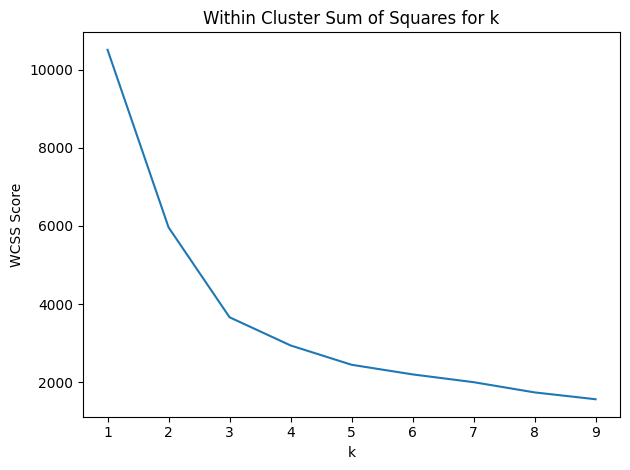

In [73]:
k_values = list(range(1,10))
wcss_list = []
for k in k_values:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit_transform(rfm_df_scaled)
    wcss_list.append(kmeans.inertia_)
plt.plot(k_values, wcss_list)
plt.xlabel("k")
plt.ylabel("WCSS Score")
plt.title("Within Cluster Sum of Squares for k")
plt.tight_layout()
plt.show()

### K-Means Clustering

In [74]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(rfm_df_scaled)

KMeans(n_clusters=3)

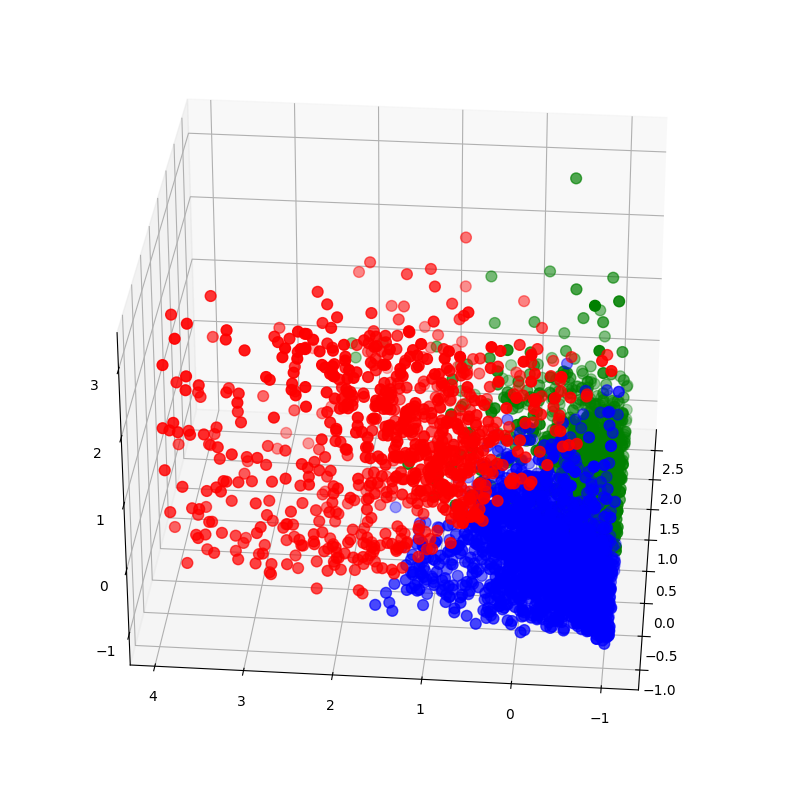

In [75]:
clusters1 = kmeans.labels_
RFM = rfm_df_scaled 
RFM['labels'] = clusters1
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(RFM["recency"][RFM.labels == 0], RFM["frequency"][RFM.labels == 0], RFM["monetary"][RFM.labels == 0], c='red', s=60)
ax.scatter(RFM["recency"][RFM.labels == 1],RFM["frequency"][RFM.labels == 1], RFM["monetary"][RFM.labels == 1], c='green', s=60)
ax.scatter(RFM["recency"][RFM.labels == 2], RFM["frequency"][RFM.labels == 2], RFM["monetary"][RFM.labels == 2], c='blue', s=60)
ax.view_init(30, 185)
plt.show()

In [76]:
RFM_df['Clusters'] = kmeans.labels_
analysis = RFM_df.groupby('Clusters').agg({
    'Recency':['mean','max','min'],
    'Frequency':['mean','max','min'],
    'Monetary':['mean','max','min','count']})
analysis

Recency             Frequency              Monetary           \
                mean  max  min        mean  max min         mean      max   
Clusters                                                                    
0          41.503145  246    0  114.162264  229   4  1716.144327  2925.91   
1         227.946833  326  126   23.170814  153   1   381.494966  2661.24   
2          48.466849  162    0   33.663014  121   1   561.920944  2033.10   

                        
             min count  
Clusters                
0         360.93   795  
1           3.75   884  
2           6.20  1825

In [77]:
# Calculate clustering metrics
silhouette = silhouette_score(rfm_df_scaled, kmeans.labels_)
db_index = davies_bouldin_score(rfm_df_scaled, kmeans.labels_)
ch_index = calinski_harabasz_score(rfm_df_scaled, kmeans.labels_)

# Print the metric scores
print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Calinski-Harabasz Index: {ch_index:.2f}")

Silhouette Score: 0.53
Davies-Bouldin Index: 0.68
Calinski-Harabasz Index: 4385.05


### Dendrogram

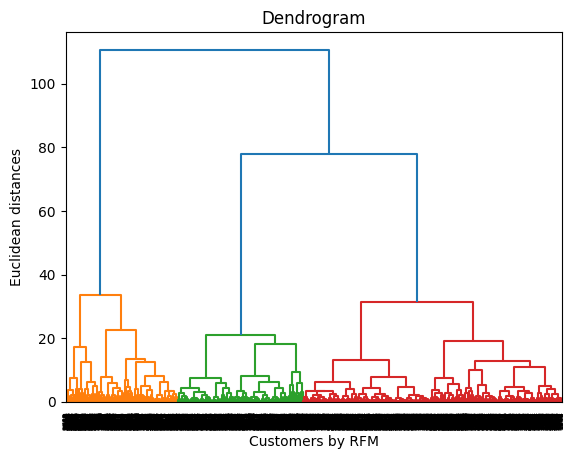

In [78]:
dendrogram = sch.dendrogram(sch.linkage(rfm_df_scaled, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers by RFM')
plt.ylabel('Euclidean distances')
plt.show()

### Hierarchical Clustering

In [79]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(rfm_df_scaled)
clusters2 = y_hc
RFM['labels'] = clusters2

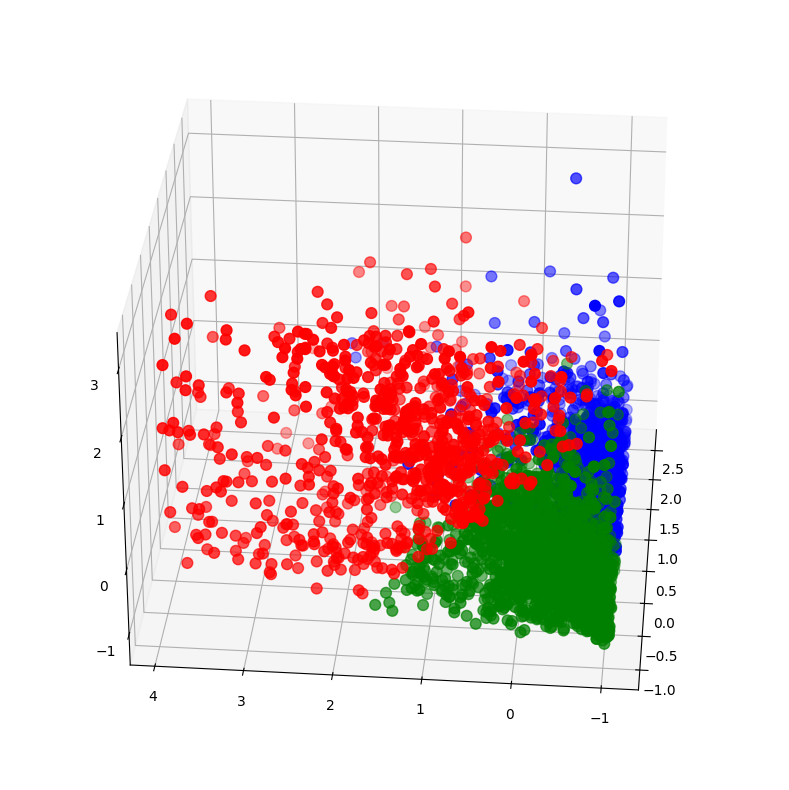

In [80]:
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(RFM["recency"][RFM.labels == 0], RFM["frequency"][RFM.labels == 0], RFM["monetary"][RFM.labels == 0], c='red', s=60)
ax.scatter(RFM["recency"][RFM.labels == 1],RFM["frequency"][RFM.labels == 1], RFM["monetary"][RFM.labels == 1], c='green', s=60)
ax.scatter(RFM["recency"][RFM.labels == 2], RFM["frequency"][RFM.labels == 2], RFM["monetary"][RFM.labels == 2], c='blue', s=60)
ax.view_init(30, 185)
plt.show()

In [81]:
RFM_df['Clusters'] = y_hc
analysis = RFM_df.groupby('Clusters').agg({
    'Recency':['mean','max','min'],
    'Frequency':['mean','max','min'],
    'Monetary':['mean','max','min','count']})
analysis

Recency             Frequency              Monetary           \
                mean  max  min        mean  max min         mean      max   
Clusters                                                                    
0          41.503145  246    0  114.162264  229   4  1716.144327  2925.91   
1          48.466849  162    0   33.663014  121   1   561.920944  2033.10   
2         227.946833  326  126   23.170814  153   1   381.494966  2661.24   

                        
             min count  
Clusters                
0         360.93   795  
1           6.20  1825  
2           3.75   884

In [82]:
# Calculate clustering metrics
silhouette = silhouette_score(rfm_df_scaled, y_hc)
db_index = davies_bouldin_score(rfm_df_scaled, y_hc)
ch_index = calinski_harabasz_score(rfm_df_scaled, y_hc)

# Print the metric scores
print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Calinski-Harabasz Index: {ch_index:.2f}")

Silhouette Score: 0.50
Davies-Bouldin Index: 0.76
Calinski-Harabasz Index: 4078.73
